# Equilibrium Binding of Transcription Factors
> If you know TF concentrations, binding site affinities, and cooperativities, can you predict probabilities for each configuration?

- toc: true
- comments: true
- hide: false

[With extensive help from [Jeremy A. Owen](https://www.mit.edu/~jaowen/)]

In [902]:
#collapse
# imports
import string
from collections import defaultdict
import itertools
from random import choice, random
from scipy.stats import bernoulli, norm, lognorm, expon as exponential
from scipy.stats import rv_discrete, rv_continuous

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle, Polygon
from matplotlib.colors import colorConverter, TABLEAU_COLORS
# colorConverter.to_rgba('mediumseagreen', alpha=.5)
import plotly.graph_objects as go

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 140
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['hatch.linewidth'] = 0.3

from IPython.core.display import HTML

ln = np.log
exp = np.exp

In [203]:
#collapse
# distribution plotting utilities
def is_discrete(dist):

    if hasattr(dist, 'dist'):
        return isinstance(dist.dist, rv_discrete)
    else: return isinstance(dist, rv_discrete)

def is_continuous(dist):

    if hasattr(dist, 'dist'):
        return isinstance(dist.dist, rv_continuous)
    else: return isinstance(dist, rv_continuous)

def plot_distrib(distrib, title=None):

    fig, ax = plt.subplots(1, 1)

    if is_continuous(distrib):
        x = np.linspace(distrib.ppf(0.001),
                        distrib.ppf(0.999), 1000)
        ax.plot(x, distrib.pdf(x), 'k-', lw=0.4)

    elif is_discrete(distrib):
        x = np.arange(distrib.ppf(0.01),
                      distrib.ppf(0.99))
        ax.plot(x, distrib.pmf(x), 'bo', ms=2, lw=0.4)

    r = distrib.rvs(size=1000)
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=200)

    if title: ax.set_title(title)
    fig_style_2(ax)
    return ax

def fig_style_2(ax):
    for side in ["right","top","left"]: ax.spines[side].set_visible(False)
    ax.get_yaxis().set_visible(False)

## Single TF

$$\newcommand{\kon}{k_{\mathrm{on}}}
\newcommand{\koff}{k_{\mathrm{off}}}$$

There exist two mathematical formalisms to describe the probabilities of molecular configurations at equilibrium: thermodynamics and kinetics. The kinetics formalism is more general: it describes a system's trajectory to equilibrium, and can describe non-equilibrium systems. The thermodynamics formalism only describes equilibrium, but requires fewer parameters to do so. We'll derive an expression for the probability of a single TFBS' occupancy with both formalisms, but proceed with the thermodynamic description alone for more elaborate configurations. 

### Kinetics

Most derivations of the probability of TFBS occupancy at equilibrium employ a kinetics formalism, so we'll walk through that first, and then explore the analog in the thermodynamics description. In the kinetic description, the parameters are **rates**. 

$$ \mathrm{TF} + \mathrm{TFBS} \underset{\koff}{\overset{\kon}{\rightleftarrows}} \mathrm{TF\colon TFBS} $$

> Note: We will assume the [Law of Mass Action](https://en.wikipedia.org/wiki/Law_of_mass_action) for well-mixed solutions throughout. 


The natural rates are the rate of TF binding $\kon$ and unbinding $\koff$. Equilibrium is reached when binding and unbinding are balanced:

$$\frac{d[\mathrm{TF\colon TFBS}]}{dt} = k_{\mathrm{on}}[\mathrm{TF}][\mathrm{TFBS}] - k_{\mathrm{off}}[\mathrm{TF\colon TFBS}] = 0 \text{ at equilibrium}$$
$$k_{\mathrm{on}}[\mathrm{TF}]_{\mathrm{eq}}[\mathrm{TFBS}]_{\mathrm{eq}} = k_{\mathrm{off}}[\mathrm{TF\colon TFBS}]_{\mathrm{eq}}$$
$$\text{(dropping eq subscript) }[\mathrm{TF\colon TFBS}] = \frac{k_{\mathrm{on}}[\mathrm{TF}][\mathrm{TFBS}]}{k_{\mathrm{off}}} = \frac{[\mathrm{TF}][\mathrm{TFBS}]}{k_{d}}$$

where $k_{d} = \frac{\koff}{\kon}$ is called the [dissociation constant](https://en.wikipedia.org/wiki/Dissociation_constant) (or equilibrium constant). We'd like to determine the probability of finding the TFBS occupied, i.e. the fraction of time it spends in the bound state. That fraction is $\frac{[\mathrm{bound}]}{([\mathrm{unbound}] + [\mathrm{bound}])} = \frac{[\mathrm{TF\colon TFBS}]}{([\mathrm{TFBS}] + [\mathrm{TF\colon TFBS}])}$. Define the denominator as $[\mathrm{TFBS}]_{0} = [\mathrm{TFBS}] + [\mathrm{TF\colon TFBS}]$ so that $[\mathrm{TFBS}] = [\mathrm{TFBS}]_{0} - [\mathrm{TF\colon TFBS}]$ and substitute: 

$$[\mathrm{TF\colon TFBS}] = \frac{[\mathrm{TF}]([\mathrm{TFBS}]_{0} - [\mathrm{TF\colon TFBS}])}{k_{d}}$$
$$[\mathrm{TF\colon TFBS}](k_d + [\mathrm{TF}]) = [\mathrm{TF}][\mathrm{TFBS}]_{0}$$
$$\frac{[\mathrm{TF\colon TFBS}]}{[\mathrm{TFBS}]_{0}} = \frac{[\mathrm{TF}]}{k_d + [\mathrm{TF}]}$$

> Note: We could also ask for this expression in terms of $[\mathrm{TF}]_0 = [\mathrm{TF}] + [\mathrm{TF\colon TFBS}]$ however, since we're considering a single TFBS, $[\mathrm{TF\colon TFBS}]$ is at most 1, and so $[\mathrm{TF}]_0 \approx [\mathrm{TF}]$. In instances of ligand-receptor binding in which that approximation cannot be made, the fraction bound is a messy quadratic. [Derivation here](https://www.med.upenn.edu/ostaplab/assets/user-content/documents/simpleligandbindingequations.pdf). 


### Thermodynamics

In the thermodynamic description, the parameters are Gibbs free energies $\Delta G$. Let's follow the derivation from [Physical Biology of the Cell](http://www.rpgroup.caltech.edu/pboc2/) (pp. 242) and consider the number microstates underlying each of the of bound and unbound macrostates, and their energies.

In order to count microstates, we imagine distributing $L$ TF molecules across a space-filling lattice with $\Omega$ sites. The energy of a TF in solution is $\varepsilon_{\mathrm{solution}}$ and the energy of a bound TF is $\varepsilon_{\mathrm{bound}}$. $\beta$ is the constant $1/k_b T$ where $k_b$ is Boltzmann's constant and $T$ is the temperature. 

<img src="../images/equilibrium_TFs/single_TF_thermodynamic.png" width=1000/>

In our case, the number of microstates in the unbound macrostate is $\frac{\Omega !}{L!(\Omega -L)!}\approx \frac{\Omega^L}{L!}$ and they each have energy $L \cdot \varepsilon_s$. The number of microstates in the bound macrostate is $\frac{\Omega !}{(L-1)!(\Omega -(L+1))}\approx \frac{\Omega^{(L-1)}}{(L-1)!}$ and they each have energy $(L-1) \varepsilon_s + \varepsilon_b$.

The [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution) describes the probability of a microstate as a function of its energy: $p(E_i) = e^{-\beta E_i}/Z$ where $Z$ is the "partition function" or simply $\sum_i e^{-\beta E_i}$ the sum of the weights of the microstates, which normalizes the distribution. In our case:


$$Z(L,\Omega)=\left(\colorbox{LightCyan}{$ \frac{\Omega^L}{L!} e^{-\beta L \varepsilon_s}$}\right) + \left(\colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}\right)$$

With that expression in hand, we can express the probability of the bound macrostate, $p_b$:

$$p_b=\frac{ \colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}}{\colorbox{LightCyan}{$\frac{\Omega^L}{L!} e^{-\beta L \varepsilon_s}$} + \colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}} \cdot \color{DarkRed}\frac{\frac{\Omega^L}{L!}e^{\beta L \varepsilon_s}}{\frac{\Omega^L}{L!}e^{\beta L \varepsilon_s}} \color{black} = \frac{(L/\Omega)e^{- \beta \Delta \varepsilon}}{1+(L/\Omega)e^{- \beta \Delta \varepsilon}}  $$

Where we have defined $\Delta \varepsilon = \varepsilon_b - \varepsilon_s$. $L/\Omega$ is really just a dimensionless TF concentration, which we'll hand-wave as being equivalent to $[\mathrm{TF}]$, which leaves us with an expression suspiciously similar to the one we derived from the kinetics formalism:

$$p_b = \frac{[\mathrm{TF}]e^{-\beta \Delta \varepsilon}}{1+[\mathrm{TF}]e^{-\beta \Delta \varepsilon}} \cdot \color{DarkRed}\frac{e^{\beta \Delta \varepsilon}}{e^{\beta \Delta \varepsilon}} \color{black} = \frac{[\mathrm{TF}]}{e^{\beta \Delta \varepsilon}+[\mathrm{TF}]}$$

From which we recapitulate an important correspondence between kinetics and thermodynamics at equilibrium: $ k_d = e^{\beta \Delta \varepsilon} = e^{\Delta \varepsilon / k_bT} $ more commonly written for different units as $k = e^{-\Delta G / RT}$.

The takeaway is that both the kinetic and thermodynamic formalisms produce an equivalent expression for the probabilities of each of the bound and unbound configurations, parameterized respectively by $k_d$ and $\Delta G$.







**References**: 
- [Physical Biology of the Cell](http://www.rpgroup.caltech.edu/pboc2/)
- [Thermodynamics of Biological Processes](https://doi.org/10.1016/B978-0-12-381268-1.00014-8)
- [Statistical Mechanics of Binding](http://www.bio-physics.at/wiki/index.php?title=Statistical_Mechanics_of_Binding)

### Sample Values

In order to compute probabilities like $p_b$, we need concrete TF concentrations $[\mathrm{TF}]$ and binding affinities (either $k_d$ or $\Delta G$). What are typical intranuclear TF concentrations and binding affinities?

#### Concentrations

A typical human cell nucleus has diameter 6μm, so spherical volume = $\frac{4}{3}\pi r^3 = \frac{4}{3}\pi (3\mathrm{\mu m})^3 \approx 113\mathrm{\mu m}^3$. ([MBoC](https://en.wikipedia.org/wiki/Cell_nucleus#:~:text=the%20average%20diameter%20of%20the%20nucleus%20is%20approximately%206%20micrometres%20(%CE%BCm).))

A typical expressed TF has a per-cell copy number range from $10^3$ - $10^6$. ([BioNumbers](http://book.bionumbers.org/what-are-the-copy-numbers-of-transcription-factors/#:~:text=Their%20concentration%20depends%20strongly%20on,106%20in%20mammalian%20cells.))


In [353]:
copy_number_range = [1e3, 1e6]
nuclear_volume = 113
N_A = 6.02214076e23

def copy_number_to_concentration(copy_number): return (copy_number / N_A) / (nuclear_volume * (1e3 / 1e18))

lower_end_molar = copy_number_to_concentration(copy_number_range[0])
upper_end_molar = copy_number_to_concentration(copy_number_range[1])

lower_end_nanomolar = lower_end_molar / 1e-9
upper_end_nanomolar = upper_end_molar / 1e-9

print('If TF copy numbers range from 1,000-1,000,000, then TF concentrations range from', str(round(lower_end_nanomolar))+'nM', 'to', str(round(upper_end_nanomolar))+'nM')


If TF copy numbers range from 1,000-1,000,000, then TF concentrations range from 15nM to 14695nM


We might also like a distribution over this range. Let's posit a lognormal, where $10^3$ and $10^6$ are the 3σ from the mean, which is $10^{4.5}$. Then $\sigma = 10^{0.5}$

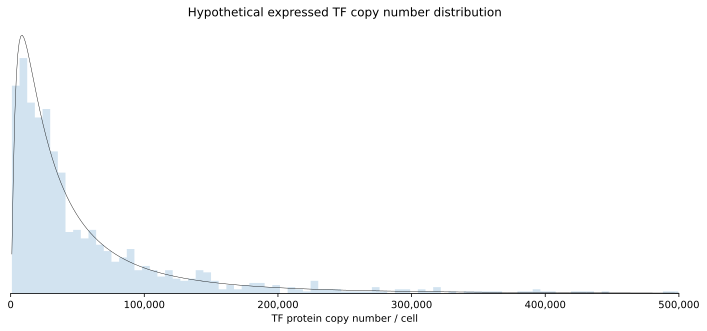

In [541]:
#collapse
# define a distribution over TF copy numbers
# Note: the lognormal is defined with base e, so we need to take some natural logs on our base 10 expression.
TF_copy_number_distrib = lognorm(scale=10**4.5, s=np.log(10**0.5))
ax = plot_distrib(d, title='Hypothetical expressed TF copy number distribution')
ax.set_xlim(left=0, right=5e5)
ax.set_xlabel('TF protein copy number / cell')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

def TF_nanomolar_concentrations_sample(n):
    return copy_number_to_concentration(TF_copy_number_distrib.rvs(n))*1e9

#### Affinities

How can we determine ΔG's of binding? We can use the prior knowledge that dissociation constants should be in the nanomolar regime ([BioNumbers](http://book.bionumbers.org/what-are-the-copy-numbers-of-transcription-factors/#:~:text=%20the%20cellular%20concentrations%20of%20transcription%20factors%20are%20often%20comparable%20to%20the%20kds%20of%20these%20proteins%20for%20dna%20binding.)). We can use the relation that $\Delta G = -k_b T \cdot \ln(k_d)$. Plugging in 310°K (human body temp) and the Boltzmann constant $k_b$ in kcal/Mol:

In [152]:
T = 310
k_b = 3.297623483e-24 * 1e-3  ## cal/K * kcal/cal
kbT = k_b*T*N_A
kbT  ## in 1/Mol -- an unusual format

0.6156213364313314

In [164]:
def nanomolar_kd_from_kcal_ΔG(ΔG): return exp(-ΔG/kbT) * 1e9
def kcal_ΔG_from_nanomolar_kd(K_d): return -kbT*ln(K_d*1e-9)

What are the ΔG's associated with each order of magnitude of a typical TF's $k_d$? How about the $\koff$ rates and half lives? To compute these, we use the approximation that $\kon$ is ~$10^5 / $ Molar $ \times $ sec  ([Wittrup](https://mitpress.mit.edu/books/quantitative-fundamentals-molecular-and-cellular-bioengineering))

In [160]:
k_on = 1e5

def k_off_from_nanomolar_k_d(k_d):
    '''k_off = k_d*k_on'''
    return (k_d*1e-9) * k_on

def half_life_from_kd(k_d):
    '''t_{1/2} = ln(2) / k_off'''
    return ln(2) / ((k_d*1e-9) * k_on)

In [313]:
#collapse
# compute statistics from kds
nanomolar_kds = pd.Series([1, 10, 100, 1000])

affinity_grid = pd.DataFrame()
affinity_grid['$k_d$'] = nanomolar_kds
affinity_grid['$\Delta G$'] = nanomolar_kds.apply(kcal_ΔG_from_nanomolar_Kd)
affinity_grid['$\kon$'] = '1e5 / (M * s)'
affinity_grid['$\koff$'] = nanomolar_kds.apply(k_off_from_nanomolar_k_d)
affinity_grid['$t_{1/2}$'] = pd.to_timedelta(nanomolar_kds.apply(half_life_from_kd), unit='s')

affinity_grid = affinity_grid.set_index('$k_d$')
affinity_grid

,$\Delta G$,$\kon$,$\koff$,$t_{1/2}$
$k_d$,,,,
1,12.757685,1e5 / (M * s),0.0001,0 days 01:55:31.471805599
10,11.340164,1e5 / (M * s),0.0010,0 days 00:11:33.147180560
100,9.922644,1e5 / (M * s),0.0100,0 days 00:01:09.314718056
1000,8.505123,1e5 / (M * s),0.1000,0 days 00:00:06.931471806


We learn that an order of magnitude residence time difference results from just 1.4 extra kcal/Mol, and that TF half lives range from about 5s to about 2h. Let's once again posit a distribution of affinities to sample from: 

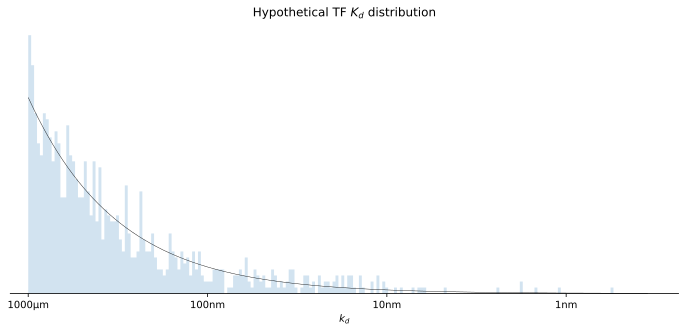

In [551]:
#collapse
# define a distribution over TF Kd's / ΔG's
TF_affinity_min = 6       ## define exponential distribution in log10 space
TF_affinity_spread = 0.5

TF_affinity_distrib = exponential(loc=TF_affinity_min, scale=TF_affinity_spread)

ax = plot_distrib(TF_affinity_distrib, title="Hypothetical TF $K_d$ distribution")

ax.set_xlim(left=5.9)
ax.set_xlabel('$k_d$')
plt.xticks([6,7,8,9], ['1000μm', '100nm', '10nm', '1nm'])

def TF_Kd_sample(n=1): return 10**(-TF_affinity_distrib.rvs(n))

def TF_ΔG_sample(n=1): return kcal_ΔG_from_nanomolar_kd(10**(-TF_affinity_distrib.rvs(n)+9))

We can finally plot our function $p_b = \frac{[\mathrm{TF}]}{e^{\beta \Delta \varepsilon}+[\mathrm{TF}]}$.

In [225]:
@np.vectorize
def fraction_bound(TF, ΔG):
    '''TF in nanomolar'''
    return TF / (TF + nanomolar_kd_from_kcal_ΔG(ΔG))

In [906]:
#collapse
# plot fraction bound as a function of concentration and binding energy

TF_concentration_array = np.logspace(1, 5)
ΔG_array = np.logspace(*np.log10([8, 13]))
TF_concs_matrix, ΔG_matrix = np.meshgrid(TF_concentration_array, ΔG_array)

z_data = pd.DataFrame(fraction_bound(TF_concs_matrix, ΔG_matrix), index=ΔG_array, columns=TF_concentration_array).rename_axis('ΔG').T.rename_axis('[TF]')

fig = go.Figure(data=[go.Surface(x=TF_concentration_array.astype(int).astype(str), y=ΔG_array.round(1).astype(str), z=z_data.values)])

fig.update_layout(
    title='',
    autosize=False,
    width=700,
    margin=dict(r=20, l=10, b=10, t=10),
    scene = dict(
        xaxis_title='[TF]',
        yaxis_title='ΔG',
        zaxis_title='Pb'),
    scene_camera = dict(eye=dict(x=-1, y=-1.8, z=1.25)))

fig.update_traces(showscale=False)

# display(fig)
HTML(fig.to_html(include_plotlyjs='cdn', include_mathjax=False))

## Multiple TFs: Direct Cooperativity & Competition

### Cooperativity

Suppose now that two TFs bind adjacent segments of DNA in such a way that the binding of either facilitates the binding of the other. We call this direct cooperativity. 

As before, we enumerate the configurations, their multiplicities, and their energies. We'll call the TFs A and B. We'll denote their counts as $A$ and $B$. The energy of a TF in solution will once more be $A_s$ and bound to its cognate TFBS $A_b$. The energy of cooperativity will be $C_{AB}$.

<table style="float:left; width:100%">
    <tr style="text-align:center; font-size:1.5rem; font-family:serif"><td>State</td><td>Energy</td><td>Multiplicity</td><td>Weight</td></tr>
    <tr><td><img src='../images/equilibrium_TFs/naked.png'  width=300/></td>
        <td>$A \cdot A_s + B \cdot B_s$</td>
        <td>$\frac{\Omega!}{(\Omega - A - B)!A!B!} \approx \frac{\Omega^{A+B}}{A!B!}$</td>
        <td>$\frac{\Omega^{A+B}}{A!B!} \cdot e^{-\beta \left[ A \cdot A_s + B \cdot B_s \right]}$</td>
    </tr>
    <tr><td><img src='../images/equilibrium_TFs/A.png'  width=300/></td>
        <td>$(A - 1) A_s + A_b + B \cdot B_s$</td>
        <td>$\frac{\Omega!}{(\Omega - (A - 1) - B)!(A-1)!B!} \approx \frac{\Omega^{A+B-1}}{(A-1)!B!}$</td>
        <td>$\frac{\Omega^{A+B-1}}{(A-1)!B!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + B \cdot B_s \right]}$</td>
    </tr>
    <tr><td><img src='../images/equilibrium_TFs/B.png'  width=300/></td>
        <td>$A \cdot A_s + (B - 1) B_s + B_b$</td>
        <td>$\frac{\Omega!}{(\Omega - A - (B - 1))!A!(B-1)!} \approx \frac{\Omega^{A+B-1}}{A!(B-1)!}$</td>
        <td>$\frac{\Omega^{A+B-1}}{A!(B-1)!} \cdot e^{-\beta \left[ A \cdot A_s + (B - 1) B_s + B_b \right]}$</td>
    </tr>
    <tr><td><img src='../images/equilibrium_TFs/AB.png' width=300 /></td>
        <td>$(A - 1) A_s + A_b + (B - 1) B_s + B_b + C_{AB}$</td>
        <td>$\frac{\Omega!}{(\Omega - (A - 1) - (B-1))!(A-1)!(B-1)!} \approx \frac{\Omega^{A+B-2}}{(A-1)!(B-1)!}$</td>
        <td>$\frac{\Omega^{A+B-2}}{(A-1)!(B-1)!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + (B - 1) B_s + B_b + C_{AB} \right]}$</td>
    </tr>
</table>

The partition function is the sum of the weights:

$$ Z = \frac{\Omega^{A+B}}{A!B!} \cdot e^{-\beta \left[ A \cdot A_s + B \cdot B_s \right]} +
\frac{\Omega^{A+B-1}}{(A-1)!B!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + B \cdot B_s \right]} +
\frac{\Omega^{A+B-1}}{A!(B-1)!} \cdot e^{-\beta \left[ A \cdot A_s + (B - 1) B_s + B_b \right]} +
\frac{\Omega^{A+B-2}}{(A-1)!(B-1)!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + (B - 1) B_s + B_b + C_{AB} \right]}$$

Which we can greatly simplify by multiplying the entire expression by the reciprocal of the "base state" weight, $\color{DarkRed}\frac{A!B!}{\Omega^{A+B}} \cdot e^{\beta \left[ A \cdot A_s + B \cdot B_s \right]}$, normalizing that weight to 1:

$$ Z = 1 +
\frac{A}{\Omega} \cdot e^{-\beta \left[ A_b-A_s \right]} +
\frac{B}{\Omega} \cdot e^{-\beta \left[ B_b-B_s \right]} +
\frac{A \cdot B}{\Omega^2} \cdot e^{-\beta \left[ A_b-A_s+B_b-B_s+C_{AB} \right]}$$

Taking the definition $[A] = A/\Omega$ and $\Delta G_A = A_b-A_s$ produces: 

$$ Z = 1 +
[A] e^{-\beta \left[ \Delta G_A \right]} +
[B] e^{-\beta \left[ \Delta G_B \right]} +
[A][B] e^{-\beta \left[ \Delta G_A+\Delta G_B+C_{AB} \right]}$$

Then the probability of any state is just the weight of that state divided by the partition function expression $Z$. 

From the above, we notice the form of the expression for the weight of a configuration of N TFBSs: 

$$ p_{\mathrm{config}} =  \prod_{i \in \, \mathrm{bound \,TBFS}} \left( [\mathrm{TF}_{\mathrm{cognate}(i)}] \cdot e^{-\beta \left[ \Delta G_i + \sum_j c_{ij} \right]}  \right) / Z$$

However, we notice a problem with evaluating this expression with realistic TF occupancy configurations: the number of configurations grows exponentially in the number of transcription factor binding sites ($2^{|\mathrm{TFBS}|}$). Only 20 Transcription Factor Binding sites entails ~1 million configurations, and so ~1 million terms in the denominator $Z$. Computing probabilities of configurations exactly then becomes intractable for realistic scenarios: we need to proceed by sampling. 

In the MCMC approach, we only need to evaluate numerators, i.e. the un-normalized probabilities of configurations. It's worth noting here that the computational effort involved is already substantial: the number of terms in the expression for the weight of a macrostate grows ~linearly with the number of TFBS, which could grow quite large. 

For [numerical stability](https://en.wikipedia.org/wiki/Log_probability#:~:text=accuracy.%20the%20use%20of%20log%20probabilities%20improves%20numerical%20stability%2C%20when%20the%20probabilities%20are%20very%20small%2C%20because%20of%20the%20way%20in%20which%20computers%20approximate%20real%20numbers.), we take the log of the unnormalized probability (that is, the weight) of configurations:

$$ \log(\tilde{p}_{\mathrm{config}}) = \sum_{i \in \, \mathrm{bound \,TBFS}} \left( \log([\mathrm{TF}_{\mathrm{cognate}(i)}]) - \beta \left[ \Delta G_i + \sum_j c_{ij} \right]  \right) $$


In order to use this expression to compute statistical weights of TF binding configurations, let's generate a hypothetical piece of DNA with transcription factor binding sites, and associated affinities and cooperativities, as well as concentrations for each TF: 

In [855]:
num_TFs = 10  ## 10 unique TFs
len_DNA = 200 ## 200bp of DNA
num_TFBS = 20 ## 20 binding sites
len_TFBS = 8  ## we'll say for simplicity sake that all TFBSs are 8bp long

TFs = list(string.ascii_uppercase[:num_TFs])  ## TF names are just letters from the alphabet
TF_conc = dict(zip(TFs, TF_nanomolar_concentrations_sample(num_TFs).astype(int)))

# TFBSs is a dataframe with columns 'TF_name', 'start', 'dG'
TFBSs = pd.DataFrame([{'TF': choice(TFs), 'start': int(random()*(len_DNA-len_TFBS)), 'dG': TF_ΔG_sample()[0]} for _ in range(num_TFBS)]).sort_values(by='start').reset_index(drop=True)


We haven't defined the distribution of cooperativities $C_{AB}$. We'll take $C_{AB}$ to be distributed around 2.2kcal/Mol. ([Forsén & Linse](https://www.sciencedirect.com/science/article/pii/S096800040089115X?via%3Dihub)). We'll posit cooperativities are exponentially distributed. 

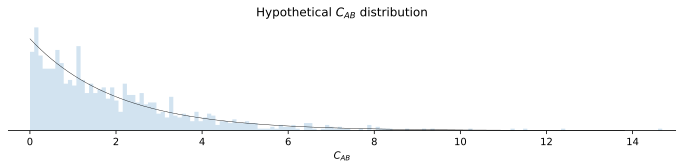

In [856]:
#collapse
# define a distribution cooperativities
cooperativity_mean_ΔG = 2.2

cooperativity_distrib = exponential(scale=1/cooperativity_spread)

ax = plot_distrib(cooperativity_distrib, title="Hypothetical $C_{AB}$ distribution")

ax.set_xlim(left=-0.5,right=15)
ax.set_xlabel('$C_{AB}$')

def C_AB_sample(n=1): return cooperativity_distrib.rvs(n)

In [857]:
def sample_cooperativities(TFBSs=TFBSs):

    cooperativities = defaultdict(lambda: dict())

    for i, tfbs_i in TFBSs.iterrows():
        for j, tfbs_j in TFBSs.iterrows():
            if i < j:
                if 7 <= abs(tfbs_i.start - tfbs_j.start) <= 10:
                    cooperativities[i][j] = cooperativities[j][i] = C_AB_sample()[0]
                elif abs(tfbs_i.start - tfbs_j.start) < 7:
                    cooperativities[i][j] = cooperativities[j][i] = -C_AB_sample()[0]

    return dict(cooperativities)

cooperativities = sample_cooperativities()

In [858]:
#collapse
# plotting function
color = dict(zip(TFs, list(TABLEAU_COLORS.values())))

def draw_config(config=None, TFBSs=TFBSs, TF_conc=TF_conc, cooperativities=cooperativities):

    if config is None: config = [0]*len(TFBSs)

    plt.rcParams['figure.figsize'] = [12, 1+int(np.sqrt(len(TFs)))]

    fig, axs = plt.subplots(ncols=2, sharey=True, gridspec_kw={'width_ratios': [4, 1]})
    genome_track = axs[0]
    conc_plot = axs[1]

    ## Concentration plot
    pd.Series(TF_conc).plot.barh(ax=conc_plot, color=list(color.values()), alpha=0.9)
    for p in conc_plot.patches:
        conc_plot.annotate(str(p.get_width())+'nm', (p.get_width() + 10*(p.get_width()>0), p.get_y() * 1.02), fontsize='x-small')

    conc_plot.axes.get_yaxis().set_visible(False)
    conc_plot.axes.get_xaxis().set_visible(False)
    conc_plot.set_frame_on(False)

    ## Genome track
    genome_track.set(ylabel='TFs', ylim=[-1, len(TFs)+1], xlabel='Genome', xlim=[0, len_DNA])
    # yticks=range(len(TFs)), yticklabels=TFs,

    for i, tfbs in TFBSs.iterrows():
        tfbs_scale = np.clip(0.01*np.exp(tfbs.dG-7), 0, 1)
        genome_track.add_patch(Rectangle((tfbs.start, TFs.index(tfbs.TF)), len_TFBS, 0.9, fc=color[tfbs.TF], alpha=tfbs_scale))
        genome_track.add_patch(Rectangle((tfbs.start, TFs.index(tfbs.TF)), len_TFBS, 0.1*tfbs_scale, fc=color[tfbs.TF], alpha=1))
        genome_track.annotate(str(int(tfbs.dG))+'kcal/Mol', (tfbs.start, TFs.index(tfbs.TF)-0.3), fontsize='xx-small')
        genome_track.add_patch(Polygon([[tfbs.start+2, TFs.index(tfbs.TF)], [tfbs.start+4,TFs.index(tfbs.TF)+0.8],[tfbs.start+6, TFs.index(tfbs.TF)]], fc=color[tfbs.TF], alpha=config[i]))

    cm = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-3, vmax=3), cmap=matplotlib.cm.PiYG)

    for i, rest in cooperativities.items():
        for j, C_AB in rest.items():
            tfbs_i = TFBSs.iloc[i]
            tfbs_j = TFBSs.iloc[j]

            if TF_conc[tfbs_i.TF] > 0 and TF_conc[tfbs_j.TF] > 0:
                xa = tfbs_i.start+(len_TFBS/2)
                xb = tfbs_j.start+(len_TFBS/2)

                ya = TFs.index(tfbs_i.TF)
                yb = TFs.index(tfbs_j.TF)

                genome_track.plot([xa, (xa+xb)/2, xb], [ya+0.9, max(ya, yb)+1.2, yb+0.9], color=cm.to_rgba(C_AB))

    genome_track.grid(axis='y', lw=0.1)
    genome_track.set_frame_on(False)

    return axs

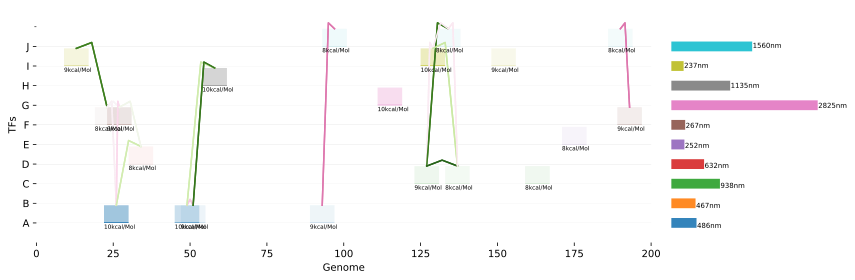

In [859]:
# draw our model regulatory region:
ax = draw_config(TFBSs=TFBSs, TF_conc=TF_conc)
plt.tight_layout()

Now we're finally prepared to compute the statistical weight of a binding configuration. Let's transcribe our formula from above:

In [929]:
#collapse
# define log_P_config()
β = 1/kbT  ## kbT was in in 1/Mol

def log_P_config(config, TF_conc=TF_conc, TFBSs=TFBSs, cooperativities=cooperativities):

    logP = 0

    for i, tfbs in TFBSs[config.astype(bool)].iterrows():

        cooperativity_sum = 0
        if i in cooperativities:
            cooperativity_sum = sum([C_AB for tfbs_j, C_AB in cooperativities[i].items() if config[tfbs_j] == 1])

        logP = sum([np.log(TF_conc[tfbs.TF]*1e-9) + β*(tfbs.dG + cooperativity_sum)])  ## the sign is flipped here, because our ΔG's of binding are positive above.

    return logP

And sample a random configuration

In [861]:
config = np.round(np.random.rand(len(TFBSs))).astype(int)

Which we can plot, and compute the associated log-statistical-weight:

log(p_config) = 0.08203543612239983


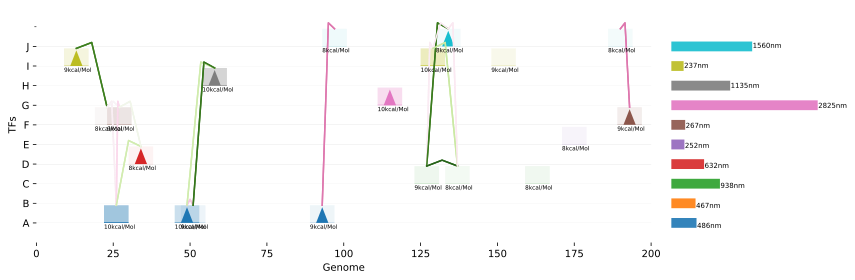

In [862]:
axs = draw_config(config)
plt.tight_layout()
print('log(p_config) =', log_P_config(config))

Let's now verify that our sampling algorithm is correct, by computing exact probabilities for simple binding site configurations: 

In [927]:
def enumerate_configs(TFBSs): return list(map(np.array, itertools.product([0,1], repeat=len(TFBSs))))

def exact_computation(TFBSs=TFBSs, TF_conc=TF_conc, cooperativities=cooperativities):

    configs = enumerate_configs(TFBSs)
    weights = []

    for config in configs:

        weights.append(np.exp(log_P_config(config, TFBSs=TFBSs, TF_conc=TF_conc, cooperativities=cooperativities)))

    return list(zip(configs, np.array(weights) / sum(weights)))


Exact computation: 	 p_config: [(array([0]), 0.7184174698836434), (array([1]), 0.28158253011635653)]
Sanity check: 		 p_bound:  0.2815825301163565


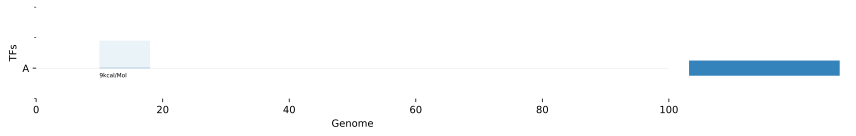

In [945]:
len_DNA =  100
TFs = ['A']
TF_conc = dict(zip(TFs, TF_nanomolar_concentrations_sample(len(TFs)).astype(int)))
TFBSs = pd.DataFrame([{'TF': 'A', 'start': 10, 'dG': TF_ΔG_sample()[0]}])

print('Exact computation: \t p_config:', exact_computation(TFBSs=TFBSs, TF_conc=TF_conc, cooperativities={}))
print('Sanity check: \t\t p_bound: ',TF_conc['A']*1e-9 / (TF_conc['A']*1e-9 + exp(-β * TFBSs.iloc[0].dG)))

ax = draw_config(TFBSs=TFBSs, TF_conc=TF_conc, cooperativities={})
plt.tight_layout()

In [ ]:
# MCMC sample -- see if we converge.

In [885]:
len_DNA =  100
TFs = ['A', 'B']
TF_conc = dict(zip(TFs, TF_nanomolar_concentrations_sample(len(TFs)).astype(int)))
TFBSs = pd.DataFrame([{'TF': 'A', 'start': 10, 'dG': TF_ΔG_sample()[0]}, {'TF': 'B', 'start': 20, 'dG': TF_ΔG_sample()[0]}])
cooperativities = {0: {1: 2}, 1: {0: 2}}

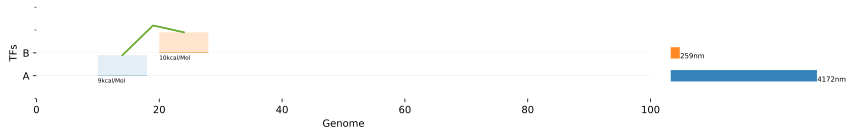

In [884]:
ax = draw_config(TFBSs=TFBSs, TF_conc=TF_conc, cooperativities=cooperativities)
plt.tight_layout()

In [897]:
exact_computation(TFBSs=TFBSs, TF_conc=TF_conc, cooperativities=cooperativities)

[(array([0, 0]), 0.010123735826274169),
 (array([0, 1]), 0.036576307037193154),
 (array([1, 0]), 0.011162692841250156),
 (array([1, 1]), 0.9421372642952826)]

Argue that we're interested in marginals, and joint marginals (over 2-3 variables)

Are we interested in the MAP?

Do we have any sort of prior? Not really, just uniform. The probability distribution is entirely specified by the thermodynamic expression

Could just do MH: use the same logic as in previous blog post. 

really it might make more sense to focus on the nucleosome expressions tomorrow morning, rather than the MCMC stuff

### Competition

**References**: 
- [Transcriptional regulation by the numbers: models](https://pubmed.ncbi.nlm.nih.gov/15797194/)

## Multiple TFs: Nucleosome-mediated Cooperativity

In [106]:
#collapse
# Get ENCODE TPM matrix and TF list
gene_tpm = pd.read_csv('../../AChroMap/data/raw/ENCODE/polyA/RSEM_gene/RSEM_gene.tpm_matrix.csv')
human_TFs_ENGSs = pd.read_csv('http://humantfs.ccbr.utoronto.ca/download/v_1.01/TFs_Ensembl_v_1.01.txt', header=None)
tf_tpm = gene_tpm[gene_tpm.gene_id.str.split('.').str[0].isin(human_TFs_ENGSs[0])].set_index('gene_id')

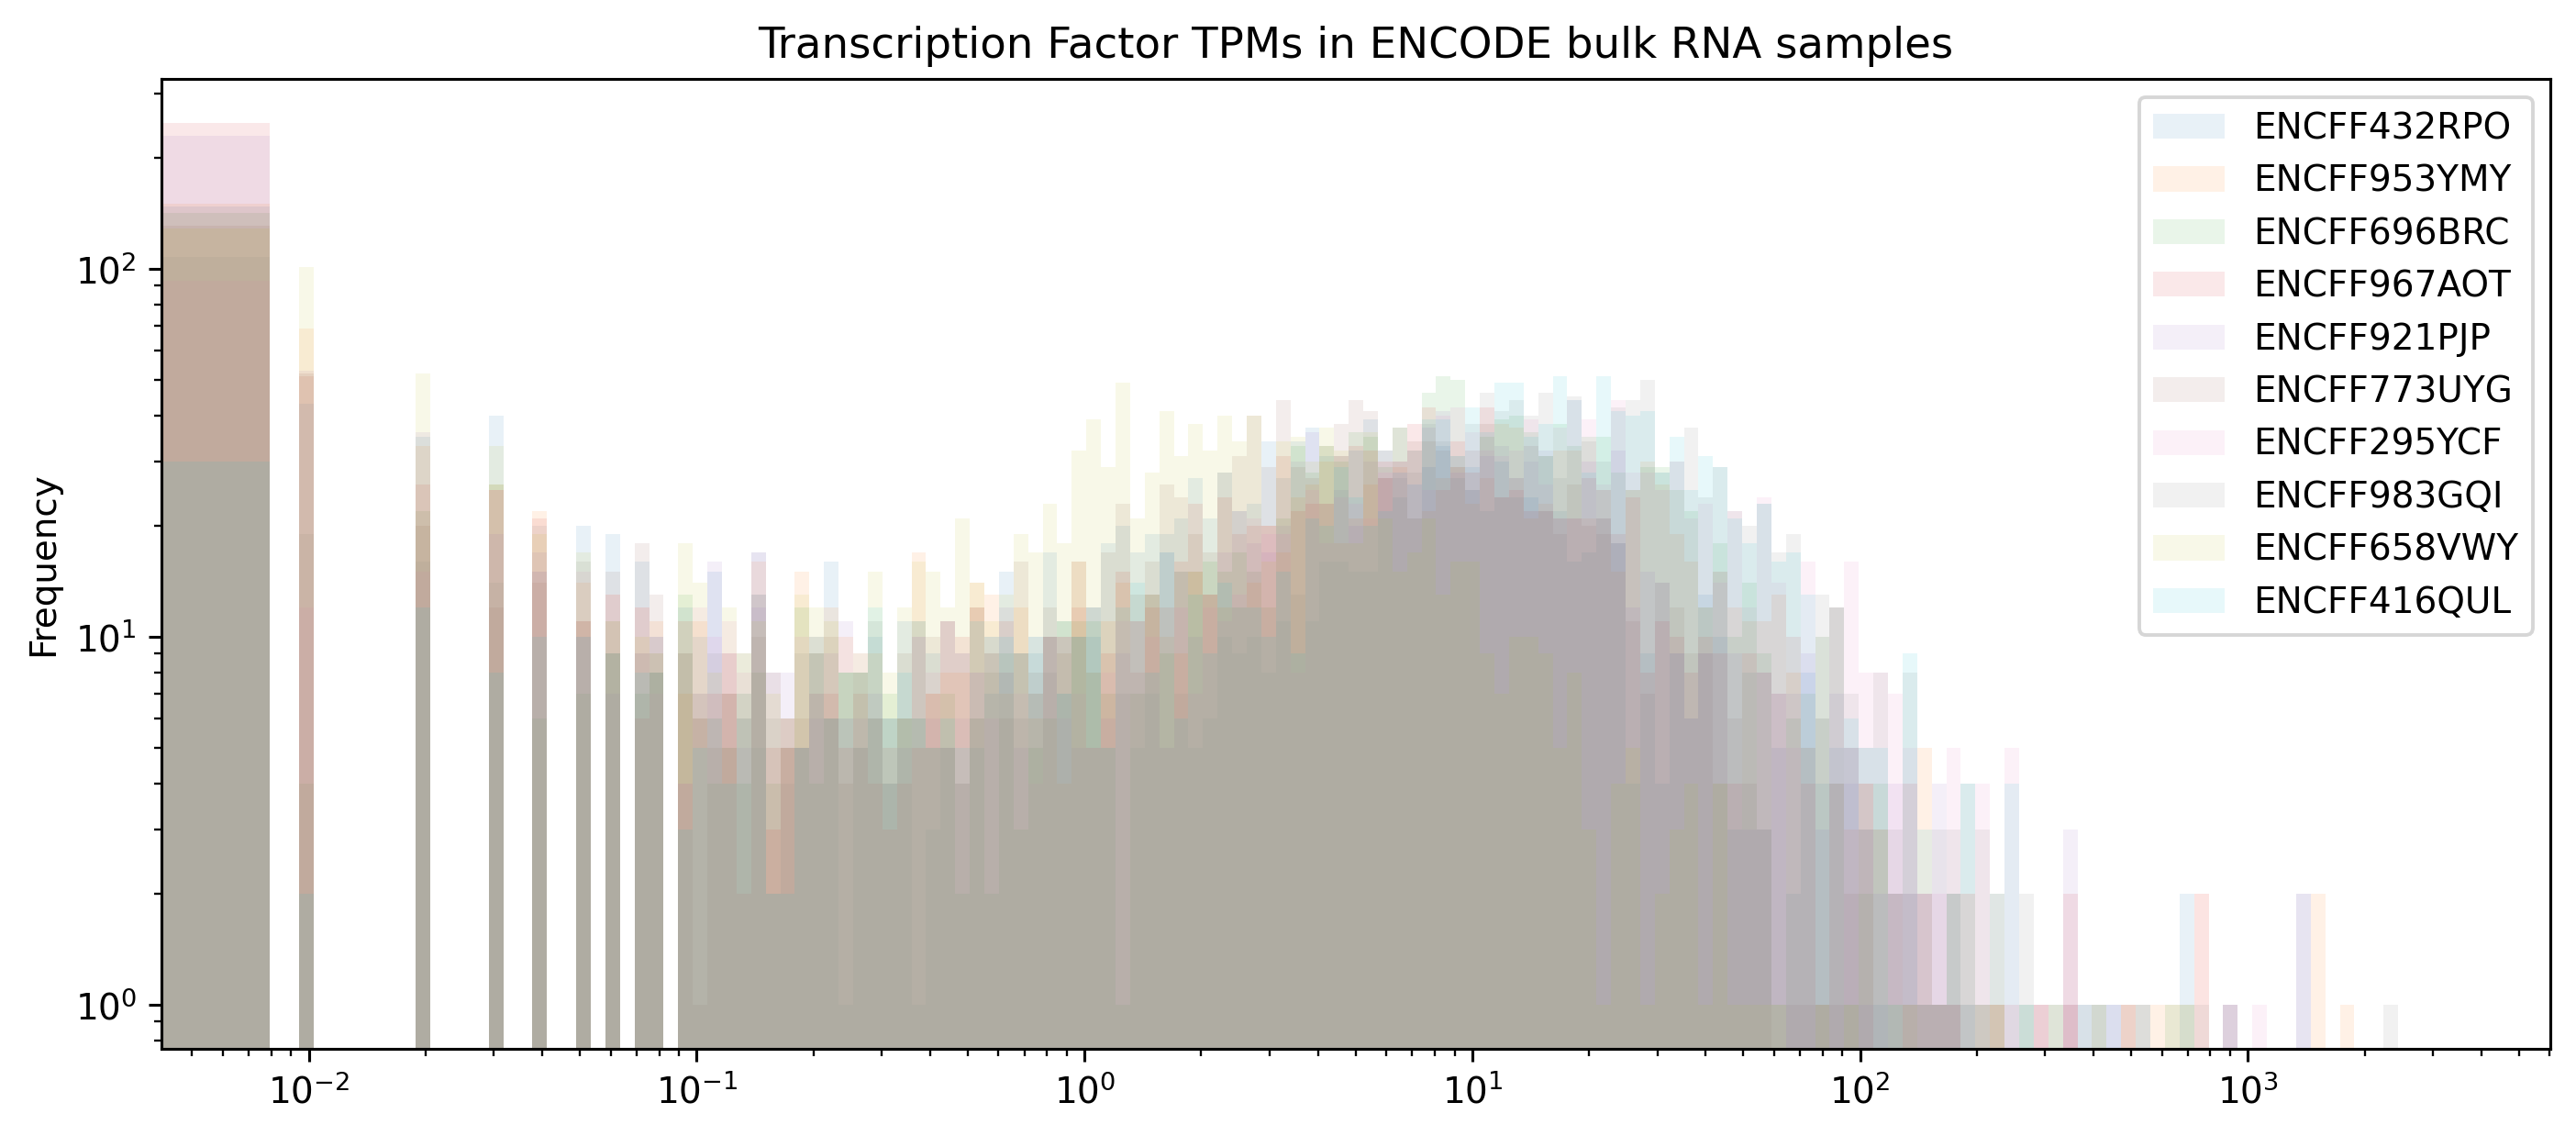

In [105]:
#collapse
tf_tpm.iloc[:, :10].plot.hist(bins=[0]+np.logspace(-2.1, 3.5, 150).tolist(), logy=True, logx=True, alpha=0.1, title="Transcription Factor TPMs in ENCODE bulk RNA samples")
None

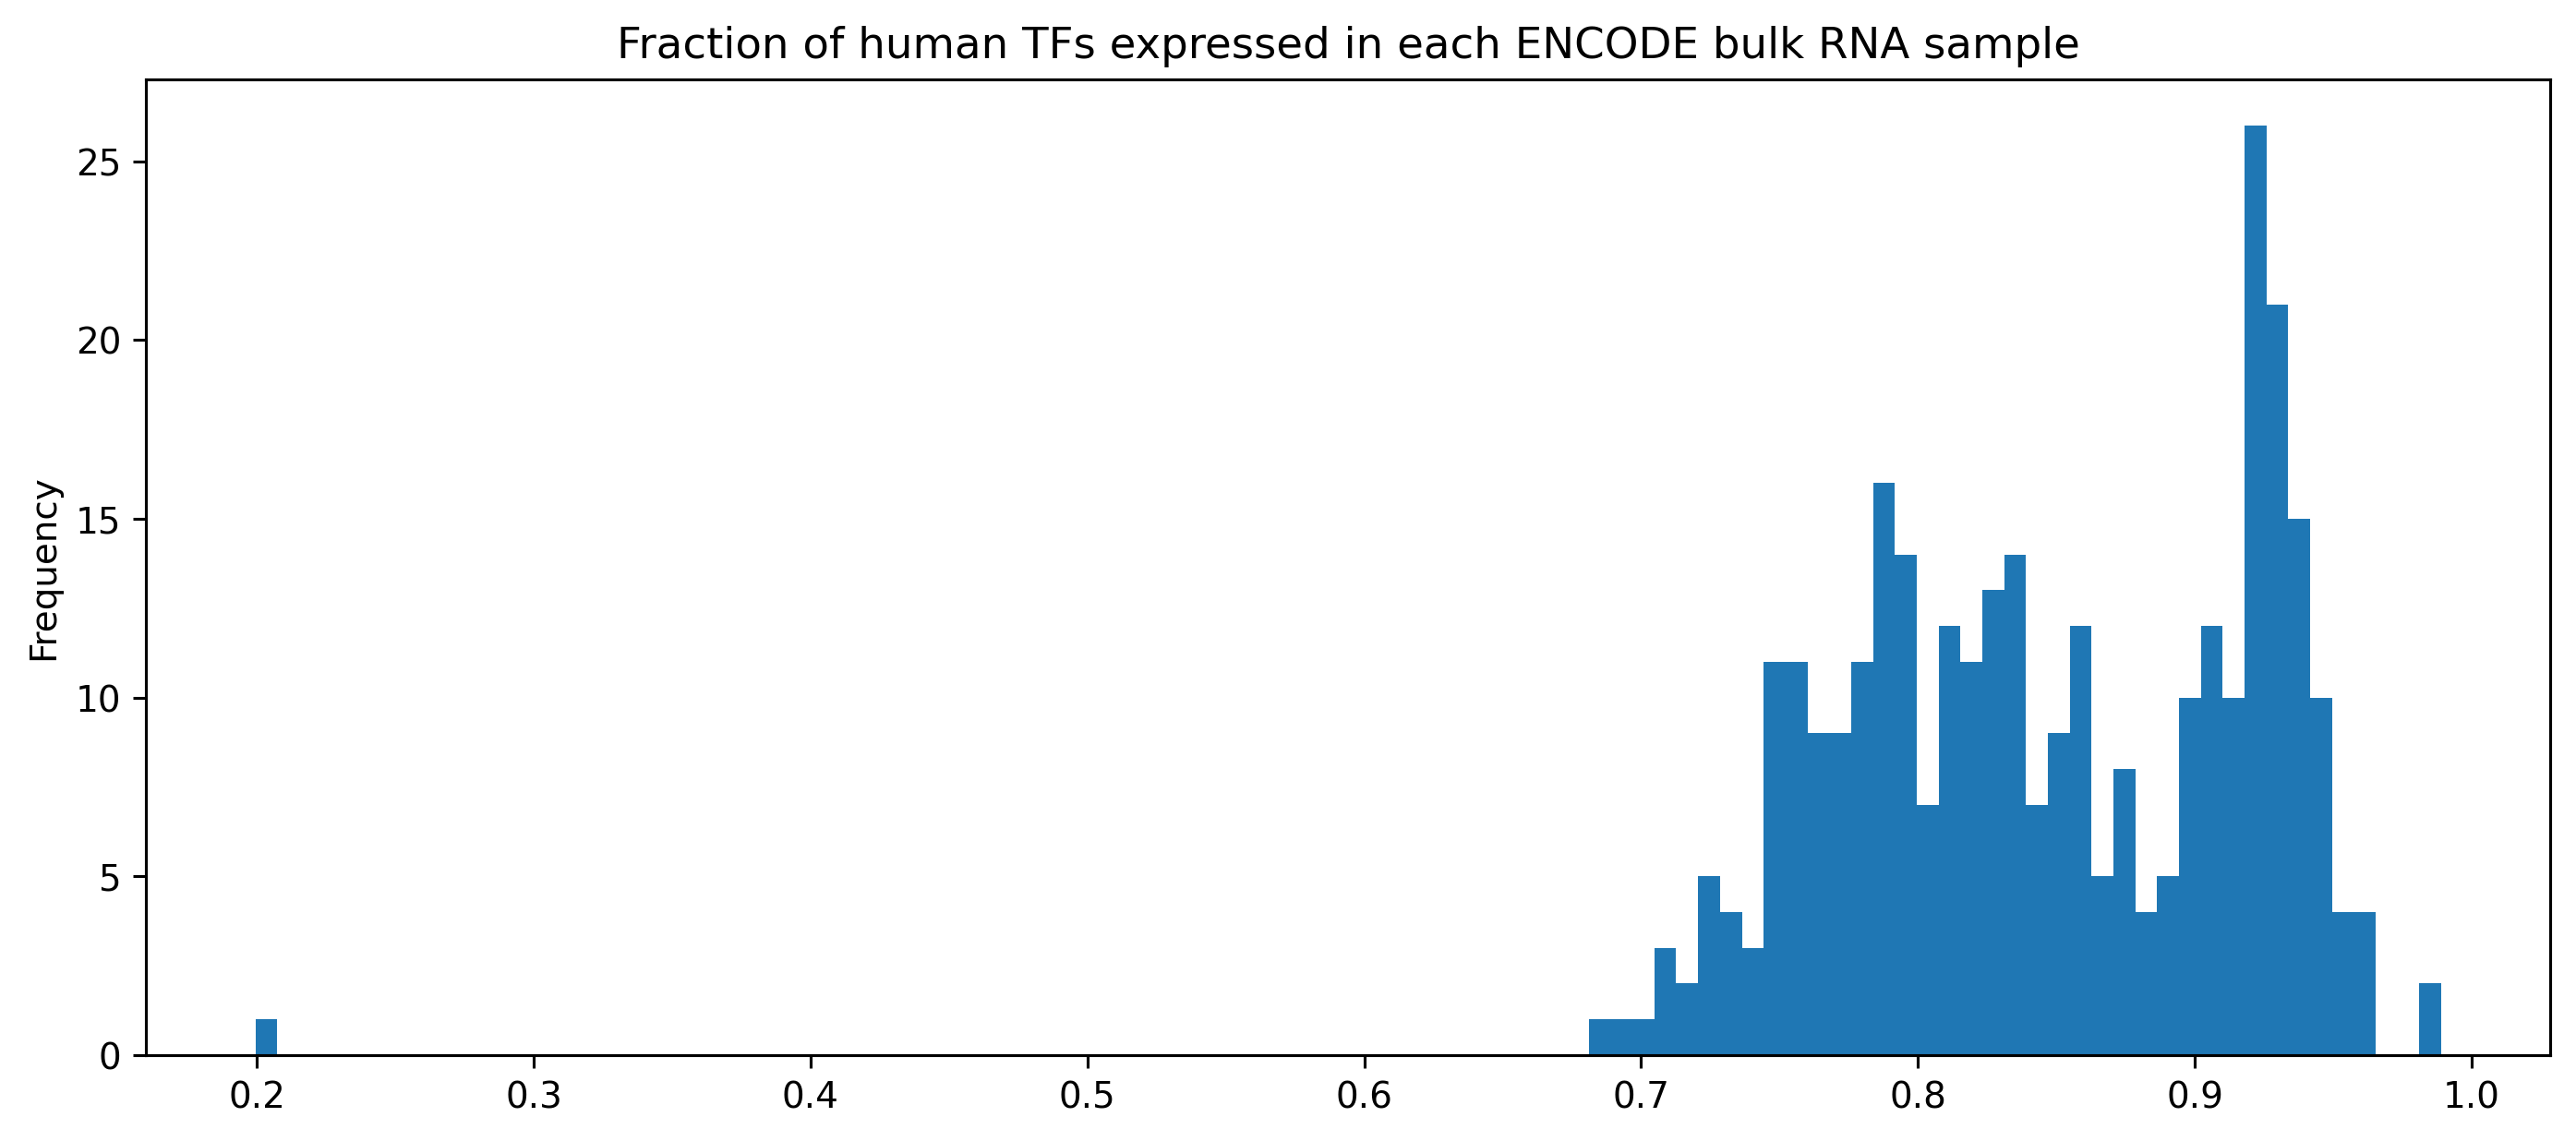

In [102]:
#collapse
((tf_tpm != 0).sum()/ len(tf_tpm)).plot.hist(bins=100, title="Fraction of human TFs expressed in each ENCODE bulk RNA sample")
None